In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow.keras.models import load_model

## Step 1: Data Cleaning

In [3]:
df = pd.read_csv('wl_ts_data.csv')

# Set 'time_met' as the index
df['time_met'] = pd.to_datetime(df['time_met'])
df.set_index('time_met', inplace=True)

# Drop columns
df = df[['wl_obs']]

# Drop rows
start_date = pd.to_datetime('2023-04-01 04:00:00')
end_date = pd.to_datetime('2024-04-30 04:00:00')
df = df[(df.index > start_date) & (df.index < end_date)]

## Step 2: Train-Test Split

In [5]:
df_train = df[df.index < pd.to_datetime('2024-04-01 04:00:00')]
df_test = df[df.index >= pd.to_datetime('2024-04-01 04:00:00')]

## Step 3: Feature Engineering

### Data normalization

Since the spike prediction is important, the min-max normalization is selected based on the distribution of wl_obs.

In [7]:
scaler = MinMaxScaler()

df_train = df_train.copy()
df_test = df_test.copy()

df_train.loc[:,'wl_scaled'] = scaler.fit_transform(df_train[['wl_obs']])
df_test.loc[:,'wl_scaled'] = scaler.transform(df_test[['wl_obs']])

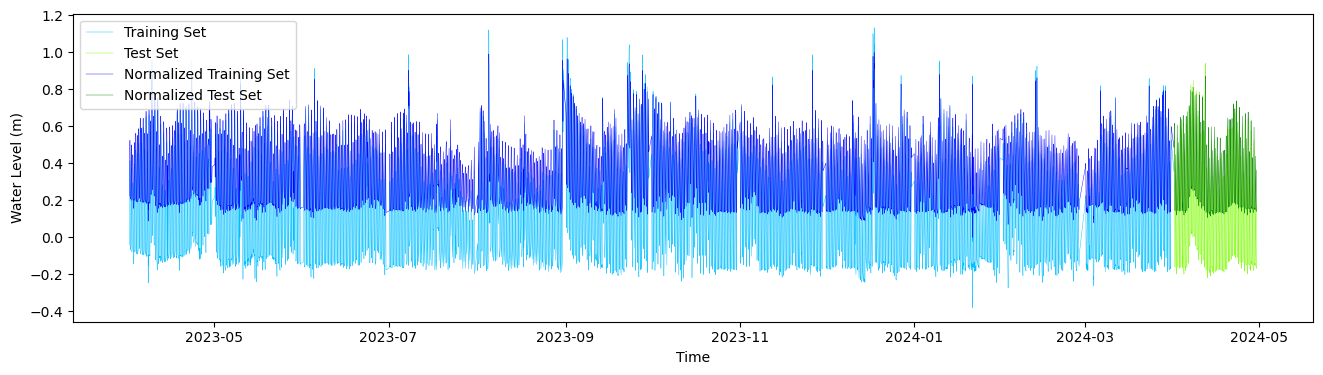

In [9]:
plt.figure(figsize=(16, 4))
plt.plot(df_train['wl_obs'], linewidth=0.3, color='deepskyblue', label='Training Set')
plt.plot(df_test['wl_obs'], linewidth=0.3, color='lawngreen', label='Test Set')
plt.plot(df_train['wl_scaled'], linewidth=0.3, color='b', label='Normalized Training Set')
plt.plot(df_test['wl_scaled'], linewidth=0.3, color='g', label='Normalized Test Set')

plt.xlabel('Time')
plt.ylabel('Water Level (m)')
plt.legend()
plt.show()

### Decomposition of time series

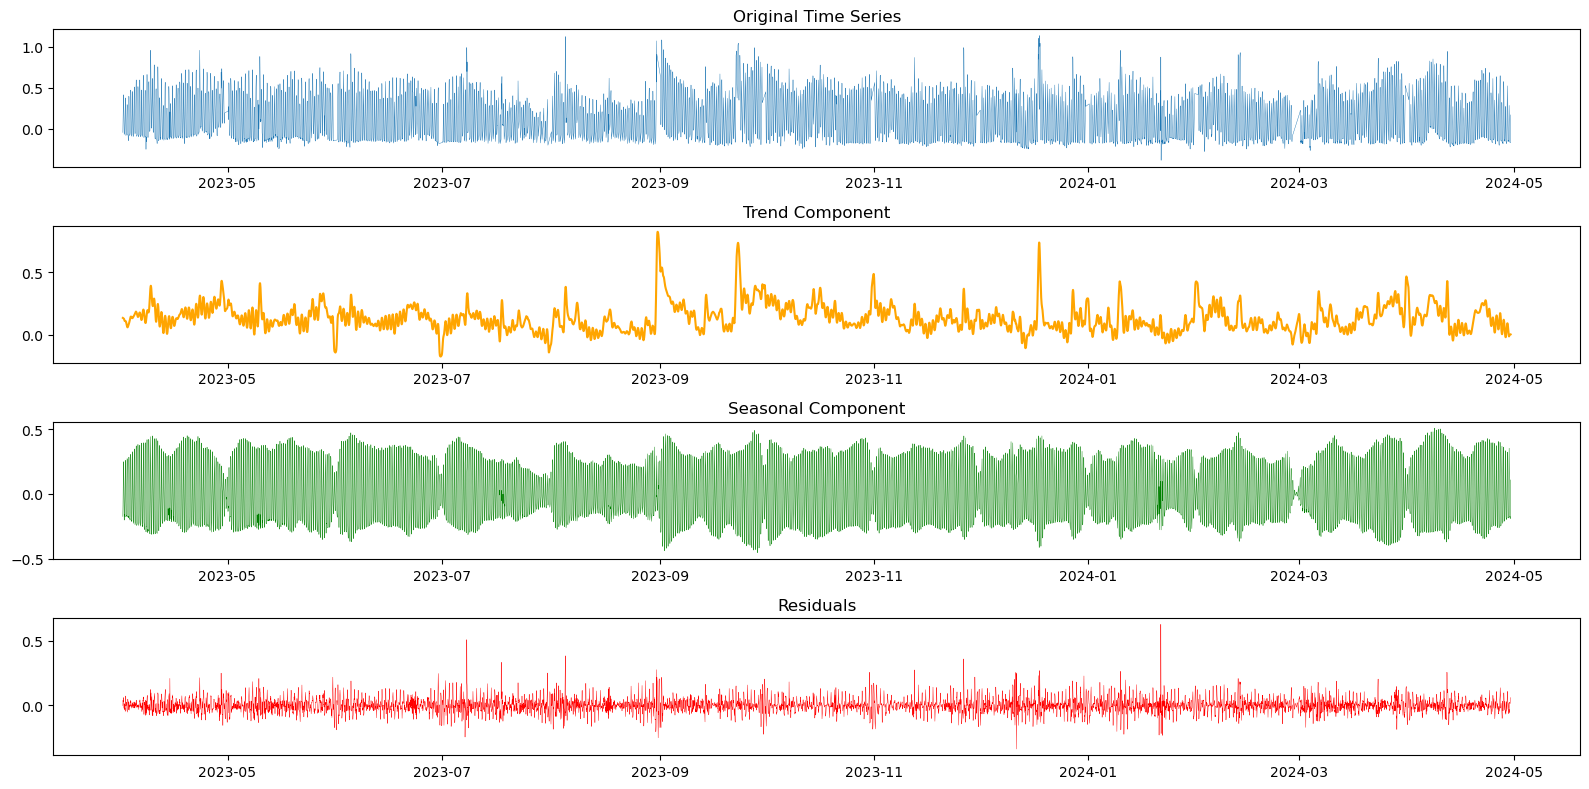

In [11]:
# Adjust the period parameter
period = 12
stl = STL(df['wl_obs'], period=period)
result = stl.fit()

plt.figure(figsize=(16, 8))
plt.subplot(411)
plt.plot(df['wl_obs'], linewidth=0.3)
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(result.trend, color='orange')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(result.seasonal, linewidth=0.3, color='green')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(result.resid, linewidth=0.3, color='red')
plt.title('Residuals')

plt.tight_layout()
plt.show()

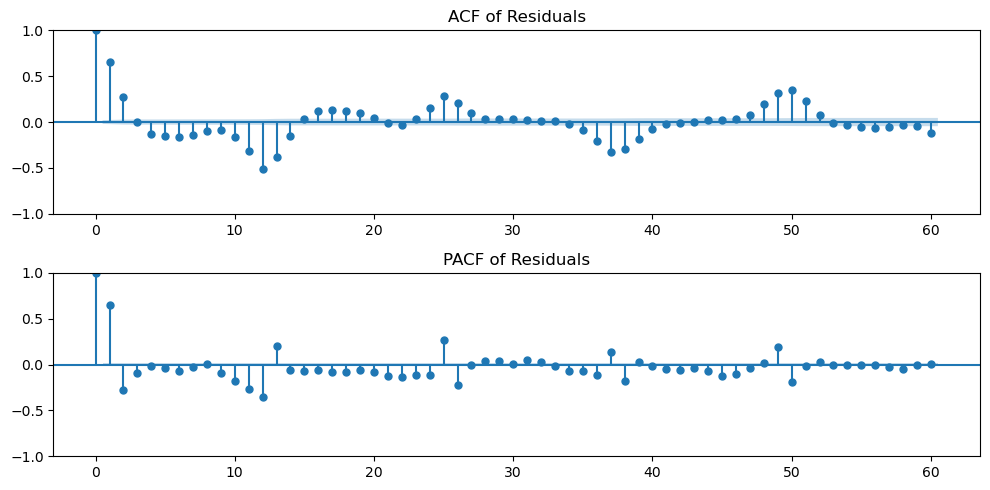

In [13]:
# Plot ACF and PACF for residuals
plt.figure(figsize=(10, 5))
plt.subplot(211)
plot_acf(result.resid.dropna(), lags=60, ax=plt.gca())
plt.title('ACF of Residuals')

plt.subplot(212)
plot_pacf(result.resid.dropna(), lags=60, ax=plt.gca())
plt.title('PACF of Residuals')

plt.tight_layout()
plt.show()

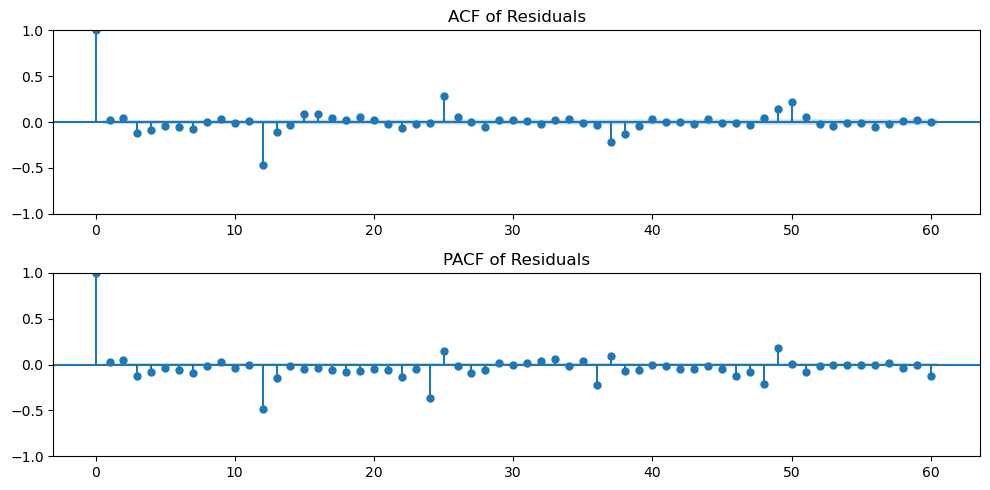

In [15]:
# Fit a SARIMA model to the residuals
result.resid.index.freq = pd.infer_freq(df.index)
model = SARIMAX(result.resid, order=(1, 0, 1), seasonal_order=(1, 0, 1, 24))
res = model.fit()

plt.figure(figsize=(10, 5))
plt.subplot(211)
plot_acf(res.resid.dropna(), lags=60, ax=plt.gca())
plt.title('ACF of Residuals')

plt.subplot(212)
plot_pacf(res.resid.dropna(), lags=60, ax=plt.gca())
plt.title('PACF of Residuals')

plt.tight_layout()
plt.show()

## Step 4: Model Selection & Implementation

### LSTM

In [17]:
# X - Features (water level in previous hours)
# y - Target (water level in the next hour)
def create_dataset(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data.iloc[i:i+look_back])
        y.append(data.iloc[i+look_back])
    return np.array(X), np.array(y)

# Use the past 10 days (240 hours) to predict the water level in the next hour
look_back = 240
X, y = create_dataset(df_train['wl_scaled'], look_back)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

test_series = pd.concat([df_train['wl_scaled'].tail(240), df_test['wl_scaled']])
X_test, y_test = create_dataset(test_series, look_back)

# Get the index for y_val and y_test
y_val_index = df_train.index[look_back+len(X_train):]
y_test_index = df.index[-len(df_test):]

# Reshape data for the model (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [21]:
# Build LSTM using TensorFlow/Keras
lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), dropout=0.2),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
# Train and save the model (architecture + weights)
history = lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[es])
lstm.save('lstm_model.keras')

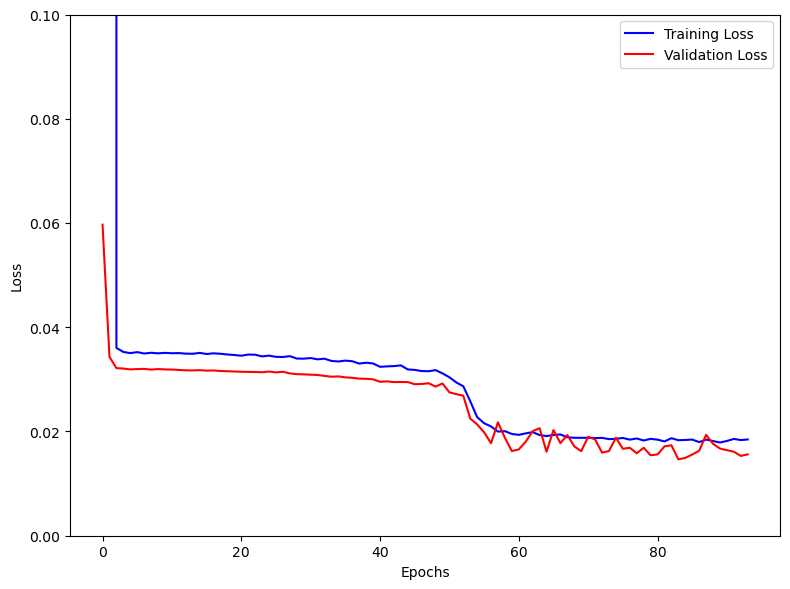

In [39]:
# Plot the training & validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.1)
plt.legend()

plt.tight_layout()
plt.show()

### Model evaluation with the test set

In [23]:
# Load the model
lstm = load_model('lstm_model.keras', compile=False)

# Make predictions
y_pred1 = lstm.predict(X_val)
y_pred2 = lstm.predict(X_test)

# Rescale the predictions and actual values to original range
y_pred1_rescaled = scaler.inverse_transform(y_pred1)
y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred2_rescaled = scaler.inverse_transform(y_pred2)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


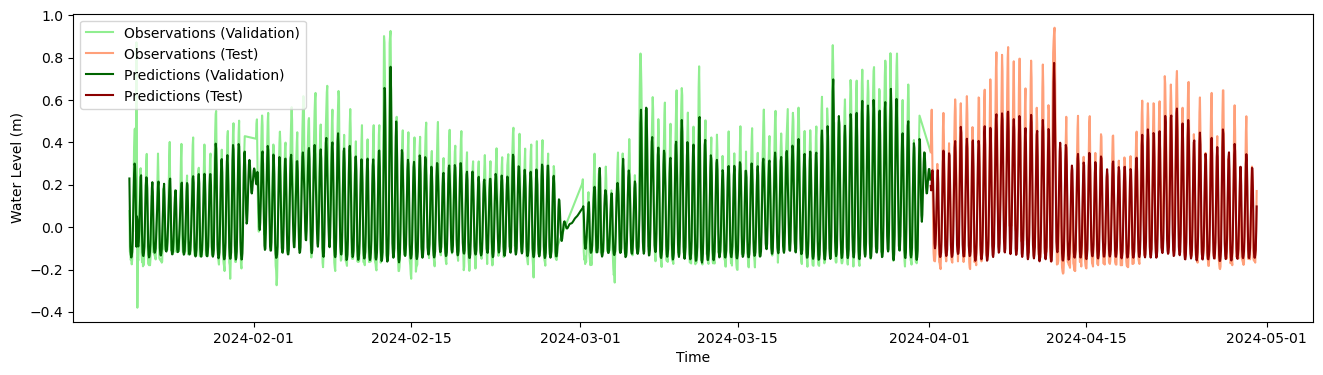

In [25]:
plt.figure(figsize=(16, 4))

# Plot observations
plt.plot(y_val_index, y_val_rescaled, color='lightgreen', label='Observations (Validation)')
plt.plot(y_test_index, y_test_rescaled, color='lightsalmon', label='Observations (Test)')

# Plot predictions
plt.plot(y_val_index, y_pred1_rescaled, color='darkgreen', label='Predictions (Validation)')
plt.plot(y_test_index, y_pred2_rescaled, color='darkred', label='Predictions (Test)')

plt.xlabel('Time')
plt.ylabel('Water Level (m)')
plt.legend()
plt.show()